# Unsupervised learning workshop

Types of unsupervised learning:
* Blind signal separation / Decomposition
* Clustering
* Anomaly detection
* More!

## Blind signal separation AKA Decomposition

Signal separation is a subject with broad applications outside of machine learning. It is used in digital signal processing, for a classical example see the [cocktail party problem](https://en.wikipedia.org/wiki/Cocktail_party_problem).

### Principal component analysis



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

cols = ["Thickness", "U Cell Size", "U Cell Shape", "Adhesion", "SE Cell Size", "Bare Nuclei", "Bland Chromatin",
       "Normal Nuclei", "Mitoses", "Class"]
patient_data = pd.read_csv("./breast-cancer-wisconsin.csv", header=None, index_col=0, names=cols)
patient_data = patient_data[patient_data.loc[:,"Bare Nuclei"] != "?"]
patient_data["Bare Nuclei"] = pd.to_numeric(patient_data["Bare Nuclei"])
patient_data["Class"] = np.where(patient_data["Class"] == 4, 1, 0)

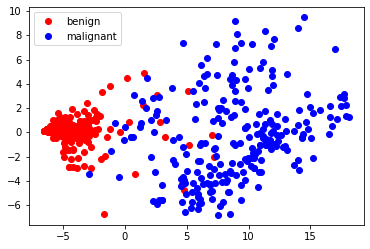

In [5]:
from sklearn.decomposition import PCA

X, y = patient_data.iloc[:,:-1], patient_data.iloc[:,-1]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.plot(X_pca[:,0][y==0], X_pca[:,1][y==0], 'o', color='r', label='benign')
plt.plot(X_pca[:,0][y==1], X_pca[:,1][y==1], 'o', color='b', label='malignant')
plt.legend()

### Explained variance




Text(0, 0.5, 'cumulative explained variance')

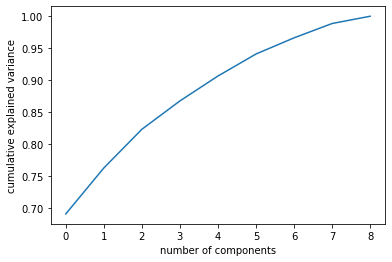

In [9]:
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

### Other forms of PCA available in scikit-learn



### TruncatedSVD



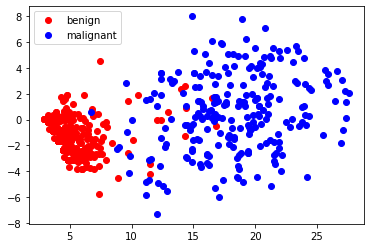

In [130]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2)
X_svd = svd.fit_transform(X)

plt.plot(X_svd[:,0][y==0], X_svd[:,1][y==0], 'o', color='r', label='benign')
plt.plot(X_svd[:,0][y==1], X_svd[:,1][y==1], 'o', color='b', label='malignant')
plt.legend(loc="upper left")

### Independent component analysis

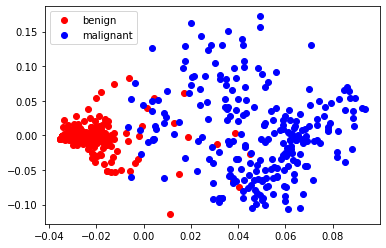

In [129]:
from sklearn.decomposition import FastICA

ica = FastICA(n_components=2)
X_ica = ica.fit_transform(X)
plt.plot(X_ica[:,0][y==0], X_ica[:,1][y==0], 'o', color='r', label='benign')
plt.plot(X_ica[:,0][y==1], X_ica[:,1][y==1], 'o', color='b', label='malignant')
plt.legend(loc="upper left")

## Clustering

One sentence explanation: Clustering will find groups or segments in the data that are similar.

Two obvious questions:
* How many groups/segments?
* What do we mean by similar?

How many groups/segments will obviously depend on the data! You might not even know ahead of time, in which case you might tune it as a hyperparameter, or use an algorithm that is agnostic to the number of clusters.

There are many ways to measure the similarity, or distance, and this can also be model dependent so it will be discussed for each model.

### Hierarchical clustering

Hierarchical clustering builds a tree-like structure of nested clusters by successively merging or splitting clusters, depending on whether a top-down (Divisive) or bottom-up (Agglomerative) approach is taken. Divisize is more complex since some other clustering algorithm needs to be run as a subroutine to decide the splitting at each step. I couldn't actually find an implementation of divisive hierarchical clustering, but Agglomerative is available in scikit-learn and scipy.

Similarity/Distance measures:
* Euclidean
* Cosine
* Manhattan
* Hamming/Jacard
* More! Generally customizable.

Clustering strategies:
* Ward: minimizes sum of squared distances of all data points within pairs of clusters. 
* Complete: minimizes maximum distance between data points in pairs of clusters.
* Average: minimizes the average of the distances between all data points of pairs of clusters.
* Single/Simple: minimizes the distance between the closest data points in pairs of clusters.

<img src="./images/clustering_affinities.png">

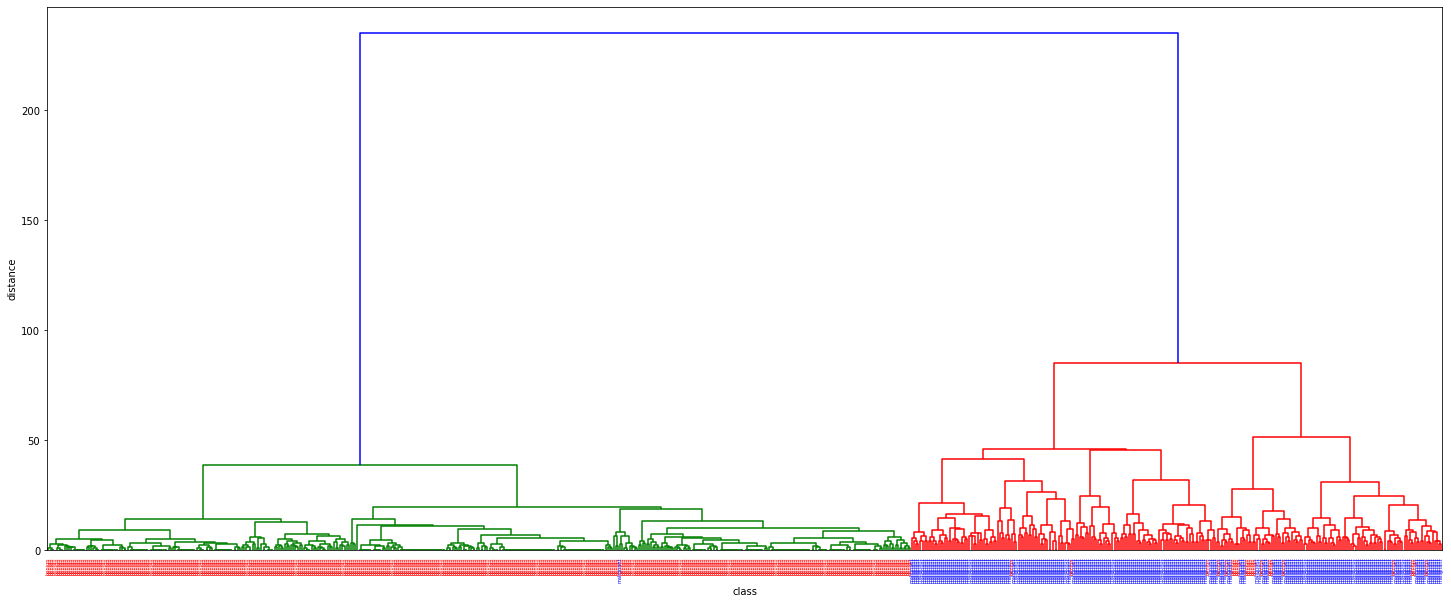

In [20]:
from scipy.cluster.hierarchy import linkage, dendrogram

Z = linkage(X, 'ward', metric='euclidean')
fig = plt.figure(figsize=(25, 10))
plt.xlabel("class")
plt.ylabel("distance")
dendro = dendrogram(Z, labels=np.where(y==0, "benign", "malignant"))
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    if lbl.get_text() == "benign":
        lbl.set_color('r')
    else:
        lbl.set_color('b')
plt.show()

### K-means clustering

Seperates data into n clusters by minimizing the inertia, or the in-cluster sum-of-squares:

Some draw backs:
* Minimizing inertia assumes clusters are convex and isotropic. Will not perform well in other situations.
* High-dimensional and/or sparse data can lead to inflated euclidean distances and poor performance. Can be alleviated to some degree by running a dimensionality reduction algorithm like PCA beforehand.



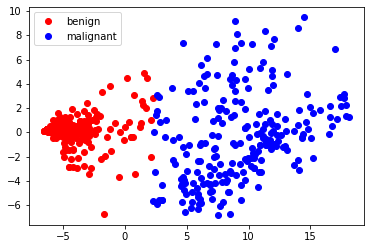

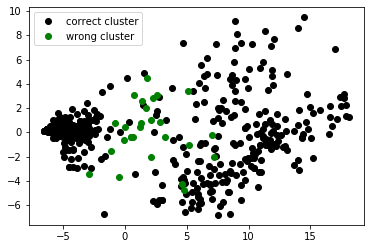

In [82]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
plt.plot(X_pca[:,0][kmeans.labels_==0], X_pca[:,1][kmeans.labels_==0], 'o', color='r', label='benign')
plt.plot(X_pca[:,0][kmeans.labels_==1], X_pca[:,1][kmeans.labels_==1], 'o', color='b', label='malignant')
plt.legend()
plt.show()
plt.plot(X_pca[:,0][kmeans.labels_==y], X_pca[:,1][kmeans.labels_==y], 'o', color='k', label='correct cluster')
plt.plot(X_pca[:,0][kmeans.labels_!=y], X_pca[:,1][kmeans.labels_!=y], 'o', color='g', label='wrong cluster')
plt.legend()
plt.show()

### DBSCAN

Estimated number of clusters: 2
Estimated number of noise points: 136


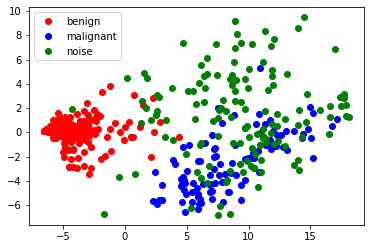

In [166]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=5, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
plt.plot(X_pca[:,0][labels==0], X_pca[:,1][labels==0], 'o', color='r', label='benign')
plt.plot(X_pca[:,0][labels==1], X_pca[:,1][labels==1], 'o', color='b', label='malignant')
plt.plot(X_pca[:,0][labels==-1], X_pca[:,1][labels==-1], 'o', color='g', label='noise')
plt.legend()

### Other clustering algorithms:



## Anomaly/outlier detection



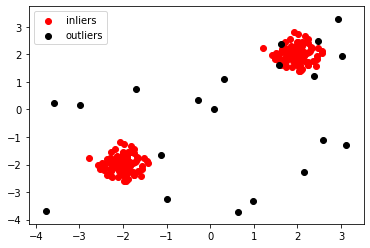

In [85]:
np.random.seed(42)

X_inliers = 0.3 * np.random.randn(100, 2)
X_inliers = np.concatenate([X_inliers + 2, X_inliers - 2], axis=0)

X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

X_all = np.concatenate([X_inliers, X_outliers], axis=0)
y_true = np.ones(len(X_all), dtype=int)
y_true[-len(X_outliers):] = -1

plt.scatter(X_inliers[:,0], X_inliers[:,1], color='r', label='inliers')
plt.scatter(X_outliers[:,0], X_outliers[:,1], color='k', label='outliers')
plt.legend()
plt.show()

### Local outlier factor

Note: LocalOutlierFactor can also be used in a supervised fashion, for example by training on X_inliers and making a prediction from X_outliers. This is generally called "novelty detection". The contamination argument should always be to 0 for novelty detection.

Prediction errors: 7


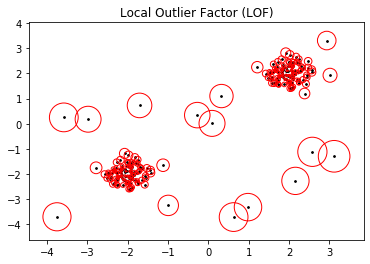

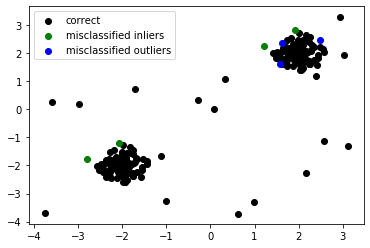

In [157]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20)
y_pred = lof.fit_predict(X_all)
n_errors = (y_pred != y_true).sum()
print("Prediction errors: {}".format(n_errors))

X_scores = clf.negative_outlier_factor_

# Plot the original data with red circles of radius proportional to the model prediction
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X_all[:, 0], X_all[:, 1], color='k', s=3., label='Data points')
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(X_all[:, 0], X_all[:, 1], s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')
plt.show()

# Plot the original data with misclassified data points highlighted
y_pred_in, y_pred_out = y_pred[:len(X_inliers)], y_pred[len(X_inliers):]
y_true_in, y_true_out = y_true[:len(X_inliers)], y_true[len(X_inliers):]
plt.scatter(X_all[:,0][y_pred == y_true], X_all[:,1][y_pred == y_true], color='k', label='correct')
plt.scatter(X_inliers[:,0][y_pred_in != y_true_in], X_inliers[:,1][y_pred_in != y_true_in], 
            color='g', label='misclassified inliers')
plt.scatter(X_outliers[:,0][y_pred_out != y_true_out], X_outliers[:,1][y_pred_out != y_true_out], 
            color='b', label='misclassified outliers')
plt.legend()
plt.show()

### Isolated Forest


Note: Much like LocalOutlierFactor, IsolatedForest can be used in for novelty detection by fitting on X_inliers and making a prediction from X_outliers. The contamination argument should be to 0 for novelty detection.

Prediction errors: 11


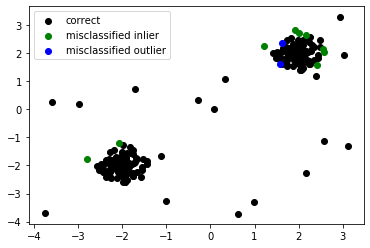

In [162]:
from sklearn.ensemble import IsolationForest

isof = IsolationForest(max_samples=200)
y_pred = isof.fit_predict(X_all)
n_errors = (y_pred != y_true).sum()
print("Prediction errors: {}".format(n_errors))
y_pred_out = isof.predict(X_outliers)
y_pred_in = isof.predict(X_inliers)

plt.scatter(X_all[:,0][y_pred == y_true], X_all[:,1][y_pred == y_true], c='k', label="correct")
plt.scatter(X_inliers[:,0][y_pred_in != y_true_in], X_inliers[:,1][y_pred_in != y_true_in], c='g', label="misclassified inlier")
plt.scatter(X_outliers[:,0][y_pred_out != y_true_out], X_outliers[:,1][y_pred_out != y_true_out], c='b', label="misclassified outlier")
plt.legend()